In [1]:
# install package

import h5py
import numpy as np
import matplotlib.pylab as py
import random
import datetime
%matplotlib inline

import torch
import torch.optim as optim

import time
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from numpy import savetxt
from numpy import loadtxt

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import linear_model

from tabulate import tabulate

In [2]:
import requests
from pathlib import Path

def download(url: str, output_path: str, mode: str = "wb") -> None:
    if Path(output_path).exists():# test if file exists (yu)
        print(f"{output_path} exits")
        return
    else:
        res: requests.Response = requests.get(url)
        if res.status_code != 200:
            raise ValueError(f"download of {url} failed with status code {res.status_code}")
        with open(output_path, mode=mode) as fp:
            fp.write(res.content)

download(
    url="https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/cs3data1.h5",
    output_path="./cs3data1.h5",
)
download(
    url="https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/cs3data2.h5",
    output_path="./cs3data2.h5",
)

./cs3data1.h5 exits
./cs3data2.h5 exits


In [3]:
# load hdf5 data
arrays={}

# grab the data from the file
filepath = ['cs3data1.h5']
# filepath = ['cs3data1.h5', 'cs3data2.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        #print(k, np.array(v)) # yu: display data in arrays
        arrays[k] = v

# display what data we have
for key in arrays.keys():
    display(key, arrays[key])

'duct_height_save'

<HDF5 dataset "duct_height_save": shape (1, 1), type "<f8">

'field_H_imag_save'

<HDF5 dataset "field_H_imag_save": shape (1201, 40), type "<f8">

'field_H_real_save'

<HDF5 dataset "field_H_real_save": shape (1201, 40), type "<f8">

'field_V_imag_save'

<HDF5 dataset "field_V_imag_save": shape (1201, 40), type "<f8">

'field_V_real_save'

<HDF5 dataset "field_V_real_save": shape (1201, 40), type "<f8">

'range_grid'

<HDF5 dataset "range_grid": shape (1201, 1), type "<f8">

In [4]:
#numranges = 1201
numranges = len(arrays[key])

# get the electric field data and reshape everything into one np array

data_h_real = np.array(arrays['field_H_real_save']).reshape(numranges, 40)
data_h_imag = np.array(arrays['field_H_imag_save']).reshape(numranges, 40)
data_v_real = np.array(arrays['field_V_real_save']).reshape(numranges, 40)
data_v_imag = np.array(arrays['field_V_imag_save']).reshape(numranges, 40)

Xraw = []
Xraw += [[data_h_real*1, data_h_imag*1, data_v_real*1, data_v_imag*1]]
Xraw = np.block(Xraw) # convert to np array
print(Xraw.shape)

# get the range data
ranges = np.zeros((numranges))
ranges = np.array(arrays['range_grid']).reshape((numranges))

yraw = []
yraw += [ranges]
yraw = np.block(yraw)

print(yraw.shape)

(1201, 160)
(1201,)


573


<Figure size 432x288 with 0 Axes>

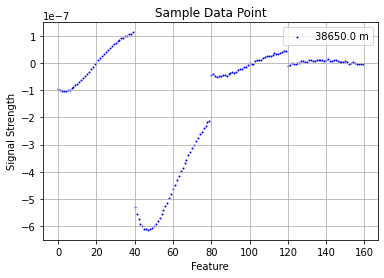

<Figure size 432x288 with 0 Axes>

In [5]:
#sample_index=np.random.randint(0,len(Xraw))
sample_index=573
print(sample_index)
plt.scatter([range(0,len(Xraw[sample_index]))], Xraw[sample_index], s=1, c='b', label=f"{yraw[sample_index]} m")
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.legend()
plt.figure()

In [6]:
def normalize(X):
  
    normedX = np.zeros_like(X)
    #normalize real (0-79) and img (80, 159) separately
    normedX[:,0:80] = X[:,0:80] / np.linalg.norm(X[:,0:80], axis=1, keepdims=True).reshape((len(X), 1))
    normedX[:,80:160] = X[:,80:160] / np.linalg.norm(X[:,80:160], axis=1, keepdims=True).reshape((len(X), 1))
    #normedX = X / np.linalg.norm(X, axis=1, keepdims=True).reshape((len(X), 1))
    return normedX



<Figure size 432x288 with 0 Axes>

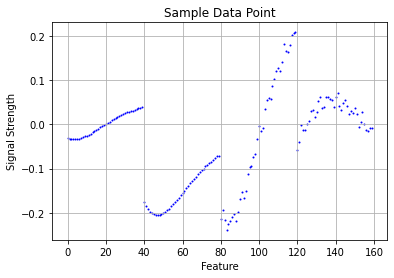

<Figure size 432x288 with 0 Axes>

In [7]:
x_norm=normalize(Xraw)
plt.scatter([range(0,len(x_norm[sample_index]))], x_norm[sample_index], s=1, c='b', label=f"{yraw[sample_index]} m")
#plt.plot(x_norm[sample_index], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

In [8]:
from sklearn.model_selection import train_test_split
XTrain,XTest = train_test_split(x_norm, test_size=0.3, shuffle=True,random_state=1)
yTrain,yTest = train_test_split(yraw, test_size=0.3, shuffle=True,random_state=1)

print(XTrain.shape)
print(XTest.shape)
print(yTrain.shape)
print(yTest.shape)

(840, 160)
(361, 160)
(840,)
(361,)


In [9]:
device = None
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    print('CUDA *not* available, use cpu')
    device = torch.device('cpu')

torch.manual_seed(50)

#training settings
batch_size = 100
num_epochs = 500
learning_rate = 1e-3
criterion = nn.MSELoss()

# print interval during the training 
print_interval=100

CUDA *not* available, use cpu


In [10]:
def train_dnn(training_inputs, training_outputs, network, epochs, learning_rate, 
          batch_size, loss_function, print_interval):
  # convert numpy data to tensor data for pytorch
  train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(training_inputs),
                                                 torch.Tensor(training_outputs))
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True)
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-5)
  track_losses = np.zeros(epochs)

  start = time.time()
  for epoch in range(1, epochs+1):

      for batch_idx, (X, y) in enumerate(train_loader):
          # grab the x's for this batch
          data = X

          # find the predictions f(x) for this batch
          output = network(data.to(device))

          # find the loss
          loss = loss_function(output, y.view([-1, 1]).to(device))

          # compute the gradient and update the network parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # housekeeping - keep track of our losses and print them as we go
      training_loss = loss.item()**.5
      track_losses[epoch-1] = training_loss
      if epoch % print_interval == 0:
          print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))
      
  return network, track_losses

In [11]:
def model_eva(XTrain,XTest,yTrain,yTest,model):
  XTrain_th=torch.FloatTensor(XTrain)
  XTest_th=torch.FloatTensor(XTest)
  #   XTrain_th=torch.FloatTensor(XTrain).cuda()
  #   XTest_th=torch.FloatTensor(XTest).cuda()
  #yTrain_th=torch.Tensor(yTrain).cuda()
  #yTest_th=torch.Tensor(yTest).cuda()

  yTrain_pred_np=model(XTrain_th).cpu().detach().numpy().reshape(-1)
  yTest_pred_np=model(XTest_th).cpu().detach().numpy().reshape(-1)

  MAE_train=mean_absolute_error(yTrain_pred_np,yTrain)
  MSE_train=mean_squared_error(yTrain_pred_np,yTrain)
  RMSE_train=np.sqrt(mean_squared_error(yTrain_pred_np,yTrain))
  R2_train=r2_score(yTrain_pred_np,yTrain)

  MAE_test=mean_absolute_error(yTest_pred_np,yTest)
  MSE_test=mean_squared_error(yTest_pred_np,yTest)
  RMSE_test=np.sqrt(mean_squared_error(yTest_pred_np,yTest))
  R2_test=r2_score(yTest_pred_np,yTest)

  return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [12]:
class mynetwork_3(nn.Module):
    def __init__(self):
        super(mynetwork_3, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.LeakyReLU(),
            nn.Linear(100,80),
            nn.LeakyReLU(),
            nn.Linear(80,50),
            nn.LeakyReLU(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [13]:
model_3 = mynetwork_3()
network_3, losses_model3 = train_dnn(XTrain, yTrain, model_3, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 7.816e+03 time:    0.5
epoch:  200 training loss: 3.801e+03 time:    1.0
epoch:  300 training loss: 3.230e+03 time:    1.4
epoch:  400 training loss: 2.332e+03 time:    1.9
epoch:  500 training loss: 1.935e+03 time:    2.4


<Figure size 432x288 with 0 Axes>

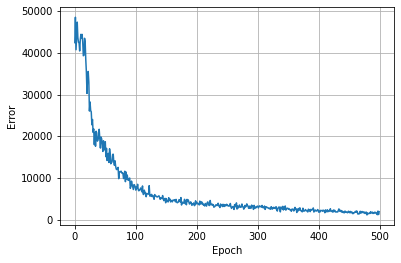

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(losses_model3)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [15]:
results=[]
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,network_3)
results.append(["NN_3",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------+----------------+----------------+-----------------+----------------+------------+------------+-------------+------------+
| Model   |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |   Test MAE |   Test MSE |   Test RMSE |   Test R^2 |
+=========+================+================+=================+================+============+============+=============+============+
| NN_3    |        1120.28 |    2.38623e+06 |         1544.74 |       0.991939 |    1602.13 | 4.8862e+06 |     2210.48 |    0.98317 |
+---------+----------------+----------------+-----------------+----------------+------------+------------+-------------+------------+


## Cross Validation

In [16]:
from sklearn.model_selection import KFold

model_3_cv = mynetwork_3()
n_splits=5
num_epochs_cv=int(num_epochs/n_splits) #total epochs are same
print_interval_cv=int(print_interval/n_splits)

kf = KFold(n_splits)

results_cv=[]
idx=0
for train_ids, test_ids in kf.split(XTrain):
    #print(train_ids, test_ids)
    XTrain_cv, XTest_cv, yTrain_cv, yTest_cv = \
        XTrain[train_ids], XTrain[test_ids], yTrain[train_ids], yTrain[test_ids]
    model_3_cv, losses_model3_cv = \
        train_dnn(XTrain_cv, yTrain_cv, model_3_cv, \
        num_epochs_cv, learning_rate, batch_size, criterion, print_interval_cv)
    MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3, \
        MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3= \
        model_eva(XTrain_cv,XTest_cv,yTrain_cv,yTest_cv,model_3_cv)
    results_cv.append([f"{++idx}",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3, \
                       R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])

print(tabulate(results_cv, headers=["Model", "Training MAE", "Training MSE", \
    "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", \
    "Test R^2"],tablefmt="grid"))


    
    

epoch:   20 training loss: 4.105e+04 time:    0.1
epoch:   40 training loss: 2.268e+04 time:    0.2
epoch:   60 training loss: 1.628e+04 time:    0.2
epoch:   80 training loss: 1.510e+04 time:    0.3
epoch:  100 training loss: 1.192e+04 time:    0.4
epoch:   20 training loss: 8.842e+03 time:    0.1
epoch:   40 training loss: 6.479e+03 time:    0.2
epoch:   60 training loss: 5.541e+03 time:    0.2
epoch:   80 training loss: 4.389e+03 time:    0.3
epoch:  100 training loss: 4.204e+03 time:    0.4
epoch:   20 training loss: 4.175e+03 time:    0.1
epoch:   40 training loss: 3.176e+03 time:    0.2
epoch:   60 training loss: 3.042e+03 time:    0.2
epoch:   80 training loss: 2.841e+03 time:    0.3
epoch:  100 training loss: 2.520e+03 time:    0.4
epoch:   20 training loss: 2.517e+03 time:    0.1
epoch:   40 training loss: 2.380e+03 time:    0.2
epoch:   60 training loss: 2.081e+03 time:    0.2
epoch:   80 training loss: 1.877e+03 time:    0.3
epoch:  100 training loss: 1.275e+03 time:    0.4


In [17]:
# evaluate nn3 trained with cross validation
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=\
    model_eva(XTrain,XTest,yTrain,yTest,model_3_cv)
results.append(["NN_3_cv",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,\
                RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", \
                                  "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+---------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+------------+
| Model   |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |   Test R^2 |
+=========+================+================+=================+================+============+=============+=============+============+
| NN_3    |       1120.28  |    2.38623e+06 |         1544.74 |       0.991939 |    1602.13 | 4.8862e+06  |     2210.48 |   0.98317  |
+---------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+------------+
| NN_3_cv |        801.562 |    1.18487e+06 |         1088.52 |       0.995996 |    1155.44 | 2.55103e+06 |     1597.19 |   0.991236 |
+---------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+------------+


# Network Design
## Activation Function

In [18]:
class mynetwork_yu_relu(nn.Module):
    def __init__(self):
        super(mynetwork_yu_relu, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(100,80),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(80,50),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x


In [19]:
model_yu_relu = mynetwork_yu_relu()
network_yu_relu, losses_yu_relu = train_dnn(XTrain, yTrain, model_yu_relu, num_epochs, learning_rate, batch_size, criterion, print_interval)


epoch:  100 training loss: 1.064e+04 time:    0.5
epoch:  200 training loss: 4.547e+03 time:    1.0
epoch:  300 training loss: 3.688e+03 time:    1.5
epoch:  400 training loss: 3.419e+03 time:    2.0
epoch:  500 training loss: 3.046e+03 time:    2.5


In [20]:
class mynetwork_yu_sig(nn.Module):
    def __init__(self):
        super(mynetwork_yu_sig, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(100,80),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(80,50),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

model_yu_sig = mynetwork_yu_sig()
network_yu_sig, losses_yu_sig = train_dnn(XTrain, yTrain, model_yu_sig, num_epochs, learning_rate, batch_size, criterion, print_interval)


epoch:  100 training loss: 4.412e+04 time:    0.5
epoch:  200 training loss: 4.180e+04 time:    1.1
epoch:  300 training loss: 4.364e+04 time:    1.6
epoch:  400 training loss: 4.406e+04 time:    2.1
epoch:  500 training loss: 4.266e+04 time:    2.7


In [21]:
class mynetwork_yu_elu(nn.Module):
    def __init__(self):
        super(mynetwork_yu_elu, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,120),
            nn.ELU(),
            nn.Linear(120,80),
            nn.ELU(),
            nn.Linear(80,40),
            nn.ELU(),
            nn.Linear(40,20),
            nn.ELU(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

model_yu_elu = mynetwork_yu_elu()
network_yu_elu, losses_yu_elu = train_dnn(XTrain, yTrain, model_yu_elu, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:  100 training loss: 6.088e+03 time:    0.7
epoch:  200 training loss: 3.786e+03 time:    1.4
epoch:  300 training loss: 3.390e+03 time:    2.1
epoch:  400 training loss: 2.682e+03 time:    2.9
epoch:  500 training loss: 2.571e+03 time:    3.6


<Figure size 432x288 with 0 Axes>

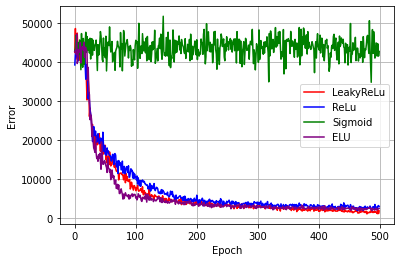

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(losses_model3,'r',label='LeakyReLu')
plt.plot(losses_yu_relu,'b',label='ReLu')
plt.plot(losses_yu_sig,'g',label='Sigmoid')
plt.plot(losses_yu_elu,'purple',label='ELU')
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [23]:
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=\
    model_eva(XTrain,XTest,yTrain,yTest,network_yu_relu)
results.append(["NN_3_relu",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,\
                RMSE_test_nn3,R2_test_nn3])
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=\
    model_eva(XTrain,XTest,yTrain,yTest,network_yu_sig)
results.append(["NN_3_sig",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,\
                RMSE_test_nn3,R2_test_nn3])
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=\
    model_eva(XTrain,XTest,yTrain,yTest,network_yu_elu)
results.append(["model_yu_elu",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,\
                RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", \
                                  "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+--------------+
| Model        |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |     Test R^2 |
+==============+================+================+=================+================+============+=============+=============+==============+
| NN_3         |       1120.28  |    2.38623e+06 |         1544.74 |    0.991939    |    1602.13 | 4.8862e+06  |     2210.48 |  0.98317     |
+--------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+--------------+
| NN_3_cv      |        801.562 |    1.18487e+06 |         1088.52 |    0.995996    |    1155.44 | 2.55103e+06 |     1597.19 |  0.991236    |
+--------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+--------------+
| NN_3

# Layer Design

In [24]:
class mynetwork_yu_4(nn.Module):
    def __init__(self):
        super(mynetwork_yu_4, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,120),
            nn.LeakyReLU(),
            nn.Linear(120,80),
            nn.LeakyReLU(),
            nn.Linear(80,40),
            nn.LeakyReLU(),
            nn.Linear(40,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

model_yu_4 = mynetwork_yu_4()
network_yu_4, losses_yu_4 = train_dnn(XTrain, yTrain, model_yu_4, num_epochs, learning_rate, batch_size, criterion, print_interval)
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=\
    model_eva(XTrain,XTest,yTrain,yTest,network_yu_4)
results.append(["model_yu_4",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,\
                RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", \
                                  "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))


epoch:  100 training loss: 5.681e+03 time:    0.6
epoch:  200 training loss: 2.678e+03 time:    1.1
epoch:  300 training loss: 1.927e+03 time:    1.6
epoch:  400 training loss: 1.284e+03 time:    2.2
epoch:  500 training loss: 1.115e+03 time:    2.7
+--------------+----------------+------------------+-----------------+----------------+------------+-------------+-------------+--------------+
| Model        |   Training MAE |     Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |     Test R^2 |
+==============+================+==================+=================+================+============+=============+=============+==============+
| NN_3         |       1120.28  |      2.38623e+06 |         1544.74 |    0.991939    |   1602.13  | 4.8862e+06  |     2210.48 |  0.98317     |
+--------------+----------------+------------------+-----------------+----------------+------------+-------------+-------------+--------------+
| NN_3_cv      |        801.56

In [25]:
class mynetwork_yu_5(nn.Module):
    def __init__(self):
        super(mynetwork_yu_5, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,120),
            nn.ELU(),
            nn.Linear(120,80),
            nn.ELU(),
            nn.Linear(80,40),
            nn.ELU(),
            nn.Linear(40,20),
            nn.LeakyReLU(),
            nn.Linear(20,1),
            nn.Dropout(0.01)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

model_yu_5 = mynetwork_yu_5()
network_yu_5, losses_yu_5 = train_dnn(XTrain, yTrain, model_yu_5, num_epochs, learning_rate, batch_size, criterion, print_interval)
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=\
    model_eva(XTrain,XTest,yTrain,yTest,network_yu_5)
results.append(["model_yu_5",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,\
                RMSE_test_nn3,R2_test_nn3])


epoch:  100 training loss: 6.001e+03 time:    0.7
epoch:  200 training loss: 3.906e+03 time:    1.5
epoch:  300 training loss: 2.719e+03 time:    2.2
epoch:  400 training loss: 2.206e+03 time:    3.0
epoch:  500 training loss: 2.439e+03 time:    3.7


In [26]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", \
                                  "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="github"))

| Model        |   Training MAE |     Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |     Test R^2 |
|--------------|----------------|------------------|-----------------|----------------|------------|-------------|-------------|--------------|
| NN_3         |       1120.28  |      2.38623e+06 |         1544.74 |    0.991939    |   1602.13  | 4.8862e+06  |     2210.48 |  0.98317     |
| NN_3_cv      |        801.562 |      1.18487e+06 |         1088.52 |    0.995996    |   1155.44  | 2.55103e+06 |     1597.19 |  0.991236    |
| NN_3_relu    |       2086.34  |      7.31897e+06 |         2705.36 |    0.973921    |   2453.08  | 1.05592e+07 |     3249.49 |  0.962748    |
| NN_3_sig     |      39915.7   |      1.89482e+09 |        43529.5  |   -2.03454e+18 |  39520.9   | 1.85984e+09 |    43125.9  | -7.98795e+18 |
| model_yu_elu |       1945.8   |      5.44215e+06 |         2332.84 |    0.981552    |   2296.12  | 7.71282e+06 |     2777.2  |  0.9737